In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette('rainbow')
sns.set_context('talk')

df = pd.read_csv('../pipeline/validated.csv')

df = df[df.valid == True]

df

image    x    y  \
0     /home/jack/Mounts/DiskOne/kona_coffee/splits/1...  299   58   
1     /home/jack/Mounts/DiskOne/kona_coffee/splits/1...  324  300   
2     /home/jack/Mounts/DiskOne/kona_coffee/splits/1...  272  321   
3     /home/jack/Mounts/DiskOne/kona_coffee/splits/1...  364  288   
9     /home/jack/Mounts/DiskOne/kona_coffee/splits/1...  109  178   
...                                                 ...  ...  ...   
1138  /home/jack/Mounts/DiskOne/kona_coffee/augmente...  136  309   
1139  /home/jack/Mounts/DiskOne/kona_coffee/augmente...  358  261   
1140  /home/jack/Mounts/DiskOne/kona_coffee/augmente...  366  367   
1141  /home/jack/Mounts/DiskOne/kona_coffee/augmente...  259  375   
1142  /home/jack/Mounts/DiskOne/kona_coffee/augmente...  268  334   

                                                   mask  valid  
0     /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   True  
1     /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   True  
2     /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   True  
3     /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   True  
9     /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   True  
...                                                 ...    ...  
1138  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   True  
1139  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   True  
1140  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   True  
1141  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   True  
1142  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   True  

[759 rows x 5 columns]

In [12]:
def get_display_image(row):
    """
    Get the display image for the mask. Crops the image to the mask.
    """
    cv2image = cv2.imread(row.image)
    cv2image = cv2.cvtColor(cv2image, cv2.COLOR_BGR2RGB)

    mask = np.load(row.mask)
    mask = mask.astype(np.uint8)
    
    # apply the mask to the image
    mask_image = cv2.bitwise_and(cv2image, cv2image, mask=mask)
    
    # choice 4 random points within the mask
    points = np.argwhere(mask)
    points = points[np.random.choice(points.shape[0], 4, replace=False)]
    
    # crop the image to the mask
    mask_image = mask_image[np.ix_(mask.any(1),mask.any(0))]
    
    return mask_image


def average_color(image, x, y, radius):
    """
    Get the average color of the circle with center (x,y) and radius
    """
    # get the circle
    circle = image[y-radius:y+radius, x-radius:x+radius, :]
    
    # get the mean of the circle
    circle_mean = np.mean(circle, axis=(0,1))
    
    return circle_mean[0], circle_mean[1], circle_mean[2]


def get_image_features(row):
    """
    Manually extract features from the image
    """
    cv2image = cv2.imread(row.image)
    cv2image = cv2.cvtColor(cv2image, cv2.COLOR_BGR2RGB)

    mask = np.load(row.mask)
    mask = mask.astype(np.uint8)

    points = np.argwhere(mask)
    points = points[np.random.choice(points.shape[0], 4, replace=False)]
    
    # for each point, get the average color of the circle around it
    features = []
    for point in points:
        features.extend(average_color(cv2image, point[1], point[0], 5))
    
    return features

    # width, height, channels = image.shape
    
    # cx, cy = width/2, height/2
    
    # c1x, c1y = width/4, height/4
    # c2x, c2y = width/4*3, height/4
    # c3x, c3y = width/4, height/4*3
    # c4x, c4y = width/4*3, height/4*3
    
    # # radius is 5% of the size of the image
    # radius = 5#width * 0.05
    
    # cp = average_color(image, int(cx), int(cy), int(radius))
    # c1 = average_color(image, int(c1x), int(c1y), int(radius))
    # c2 = average_color(image, int(c2x), int(c2y), int(radius))
    # c3 = average_color(image, int(c3x), int(c3y), int(radius))
    # c4 = average_color(image, int(c4x), int(c4y), int(radius))
    
    # return [
    #     *cp,
    #     *c1,
    #     *c2,
    #     *c3,
    #     *c4
    # ]

In [13]:
from tqdm import tqdm

fdf = []

for row in tqdm(df.itertuples(), total=len(df)):
    image = get_display_image(row)
    features = get_image_features(row)
    fdf.append([row.image, row.mask, features])

fdf = pd.DataFrame(fdf, columns=['image', 'mask', 'features'])

# fdf['red_c'] = fdf.features.apply(lambda x: x[0]/255)
# fdf['green_c'] = fdf.features.apply(lambda x: x[1]/255)
# fdf['blue_c'] = fdf.features.apply(lambda x: x[2]/255)

index = 0
for i in range(1,5):
    fdf[f'red_p{i}'] = fdf.features.apply(lambda x: x[index+0]/255)
    fdf[f'green_p{i}'] = fdf.features.apply(lambda x: x[index+1]/255)
    fdf[f'blue_p{i}'] = fdf.features.apply(lambda x: x[index+2]/255)
    index += 3

fdf = fdf.dropna()

fdf

100%|██████████| 759/759 [00:07<00:00, 103.32it/s]


image  \
0    /home/jack/Mounts/DiskOne/kona_coffee/splits/1...   
1    /home/jack/Mounts/DiskOne/kona_coffee/splits/1...   
2    /home/jack/Mounts/DiskOne/kona_coffee/splits/1...   
3    /home/jack/Mounts/DiskOne/kona_coffee/splits/1...   
4    /home/jack/Mounts/DiskOne/kona_coffee/splits/1...   
..                                                 ...   
754  /home/jack/Mounts/DiskOne/kona_coffee/augmente...   
755  /home/jack/Mounts/DiskOne/kona_coffee/augmente...   
756  /home/jack/Mounts/DiskOne/kona_coffee/augmente...   
757  /home/jack/Mounts/DiskOne/kona_coffee/augmente...   
758  /home/jack/Mounts/DiskOne/kona_coffee/augmente...   

                                                  mask  \
0    /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
1    /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
2    /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
3    /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
4    /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
..                                                 ...   
754  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
755  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
756  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
757  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
758  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   

                                              features    red_p1  green_p1  \
0    [44.33, 30.62, 24.02, 123.18, 84.9, 158.67, 58...  0.173843  0.120078   
1    [18.46, 20.88, 18.56, 28.12, 32.46, 32.1, 7.9,...  0.072392  0.081882   
2    [13.71, 15.03, 12.04, 14.24, 16.26, 13.46, 36....  0.053765  0.058941   
3    [122.59, 104.04, 167.7, 50.24, 51.72, 61.42, 3...  0.480745  0.408000   
4    [175.82, 49.26, 49.38, 161.15, 41.11, 27.14, 5...  0.689490  0.193176   
..                                                 ...       ...       ...   
754  [113.56, 9.08, 18.28, 144.52, 24.19, 46.57, 13...  0.445333  0.035608   
755  [82.84, 18.63, 6.63, 133.98, 18.44, 27.16, 56....  0.324863  0.073059   
756  [192.42, 57.22, 29.5, 180.09, 60.9, 21.94, 26....  0.754588  0.224392   
757  [153.5, 138.18, 26.18, 203.36, 171.59, 23.17, ...  0.601961  0.541882   
758  [89.06, 78.54, 28.53, 83.4, 76.33, 25.89, 65.9...  0.349255  0.308000   

      blue_p1    red_p2  green_p2   blue_p2    red_p3  green_p3   blue_p3  \
0    0.094196  0.483059  0.332941  0.622235  0.227686  0.141765  0.163647   
1    0.072784  0.110275  0.127294  0.125882  0.030980  0.040078  0.026196   
2    0.047216  0.055843  0.063765  0.052784  0.142627  0.172667  0.118235   
3    0.657647  0.197020  0.202824  0.240863  0.134039  0.163373  0.151569   
4    0.193647  0.631961  0.161216  0.106431  0.224510  0.021765  0.012235   
..        ...       ...       ...       ...       ...       ...       ...   
754  0.071686  0.566745  0.094863  0.182627  0.547647  0.121137  0.059569   
755  0.026000  0.525412  0.072314  0.106510  0.220549  0.000392  0.000392   
756  0.115686  0.706235  0.238824  0.086039  0.105843  0.106863  0.044000   
757  0.102667  0.797490  0.672902  0.090863  0.550235  0.453804  0.106745   
758  0.111882  0.327059  0.299333  0.101529  0.258784  0.266235  0.072392   

       red_p4  green_p4   blue_p4  
0    0.546980  0.336471  0.189569  
1    0.189333  0.184980  0.167216  
2    0.189216  0.207176  0.157569  
3    0.216627  0.232431  0.200353  
4    0.418824  0.016588  0.035608  
..        ...       ...       ...  
754  0.201176  0.073451  0.138863  
755  0.069451  0.000235  0.000314  
756  0.731294  0.281098  0.105451  
757  0.492863  0.437333  0.043412  
758  0.302863  0.330824  0.098431  

[727 rows x 15 columns]

In [17]:
from sklearn.cluster import KMeans

def kmeans_inertia(scaled_data, k, alpha_k=0.02):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia


def best_kmeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kmeans_inertia(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results


def plot_sample_images_from_groups(data):
    for group in data.groupby('labels'):
        dfg = group[1]
        
        # display distribution of red, green, blue
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        axes = axes.flatten()
        # for i, color in enumerate(['red_c', 'green_c', 'blue_c']):
        #     sns.histplot(
        #         dfg[color],
        #         ax=axes[i],
        #         kde=True,
        #         color=color[:-2]
        #     )
        
        # sample 10 images from the group
        sample = dfg.sample(50, replace=True)
        
        # plot the images
        fig, axes = plt.subplots(5, 10, figsize=(15, 15))
        
        # set padding to 5px
        fig.tight_layout(pad=0.01)
        
        # no axis
        for ax in axes.flatten():
            ax.axis('off')
        
        axes = axes.flatten()
        for i, row in enumerate(sample.itertuples()):
            image = get_display_image(row)
            axes[i].imshow(image)
            
        # set title to the group label
        fig.suptitle(f'Group: {group[0]}, total: {len(dfg)}')
        plt.show()

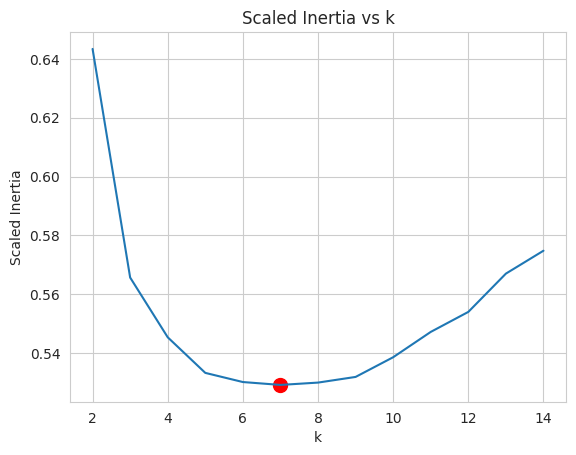

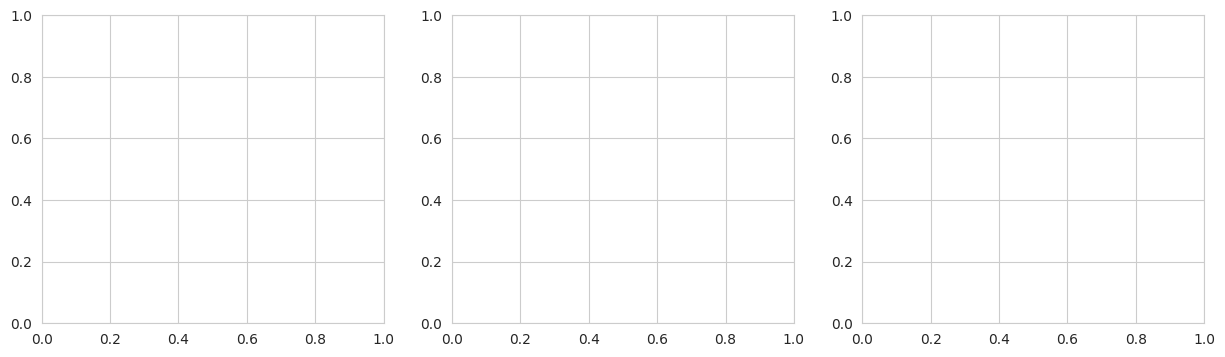

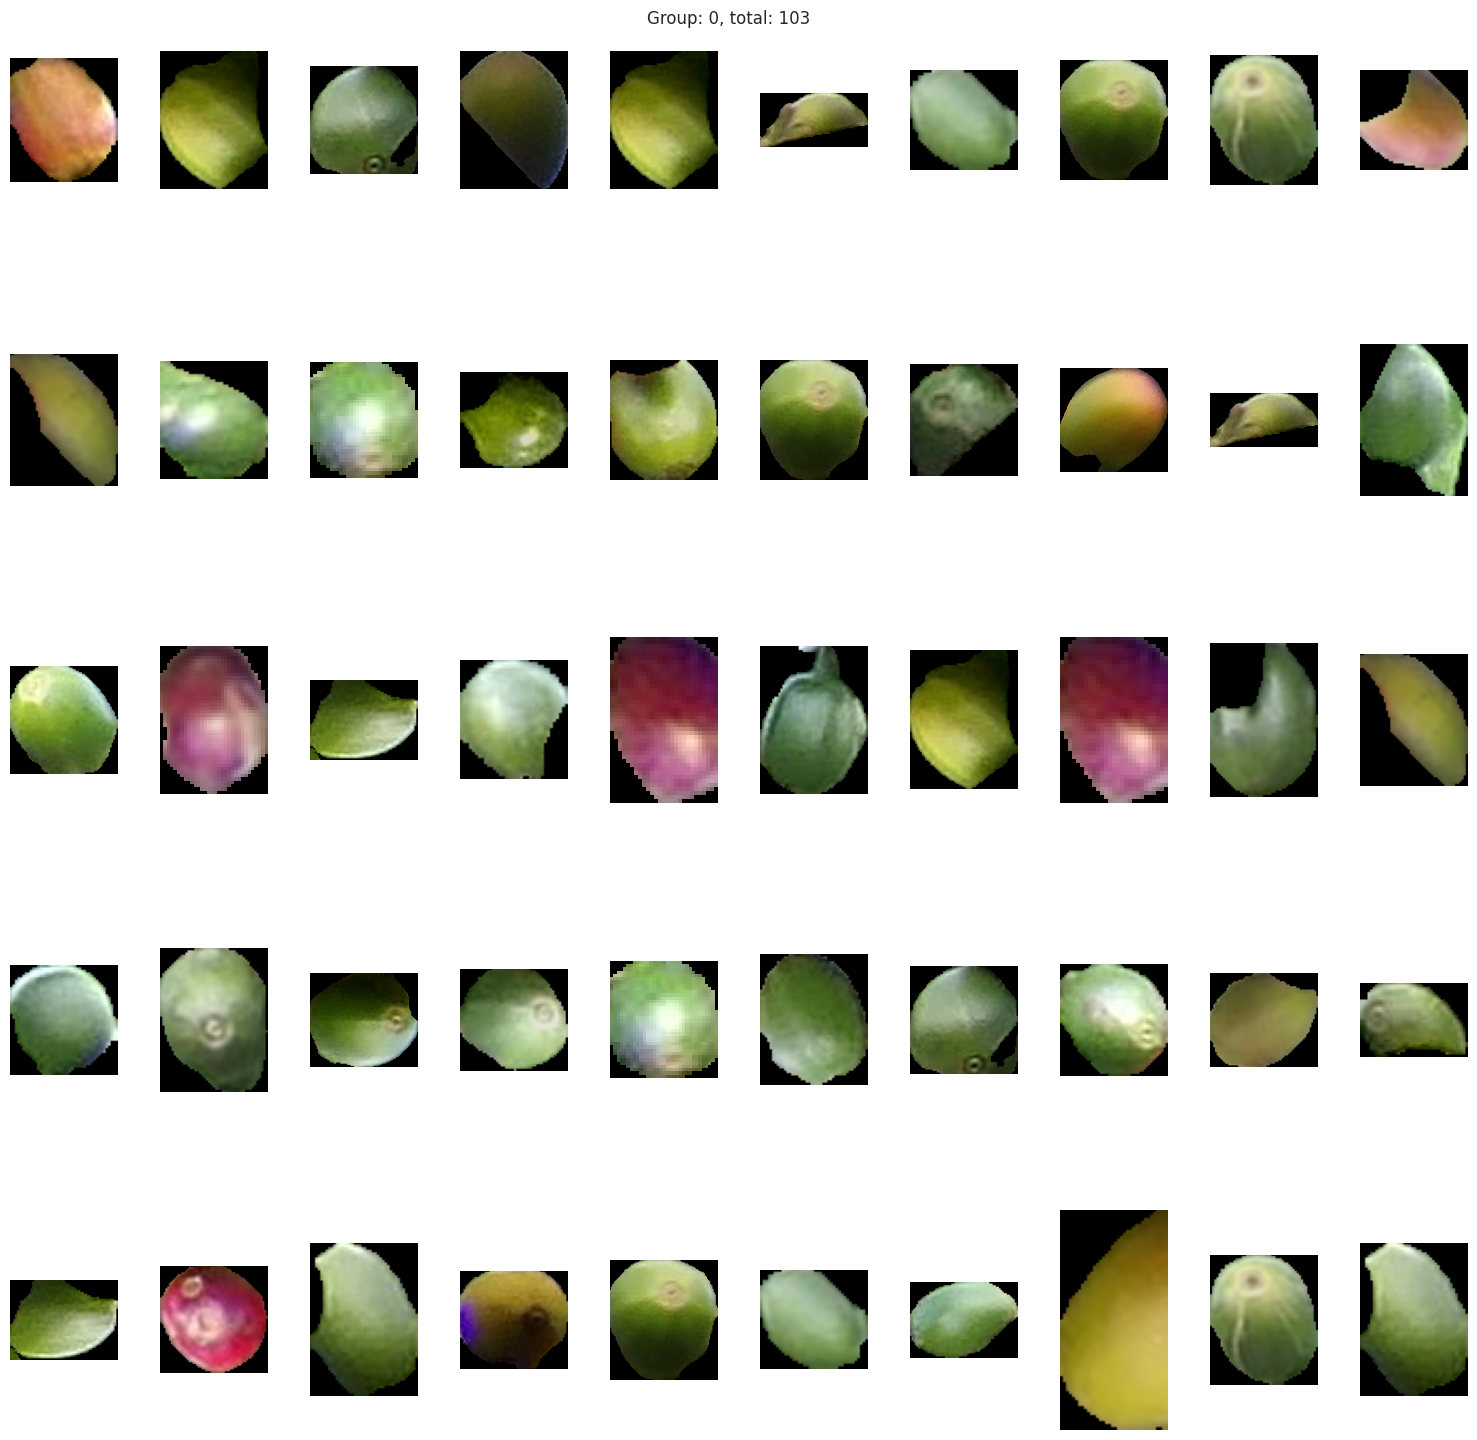

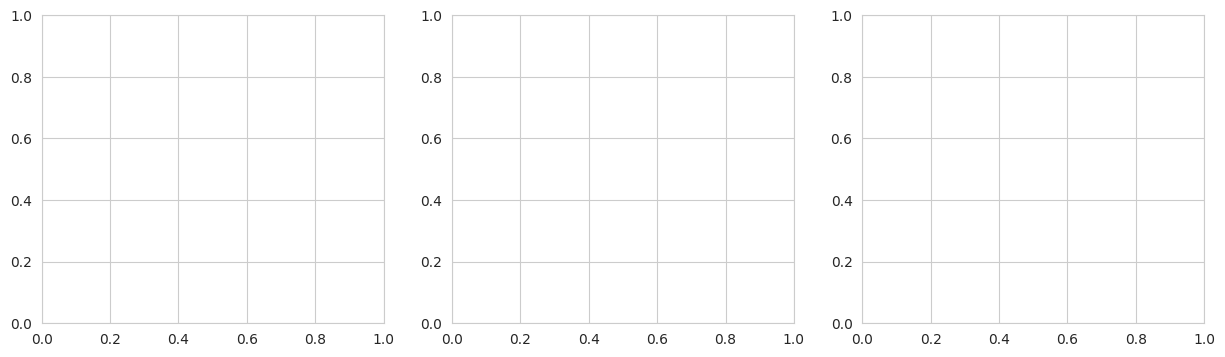

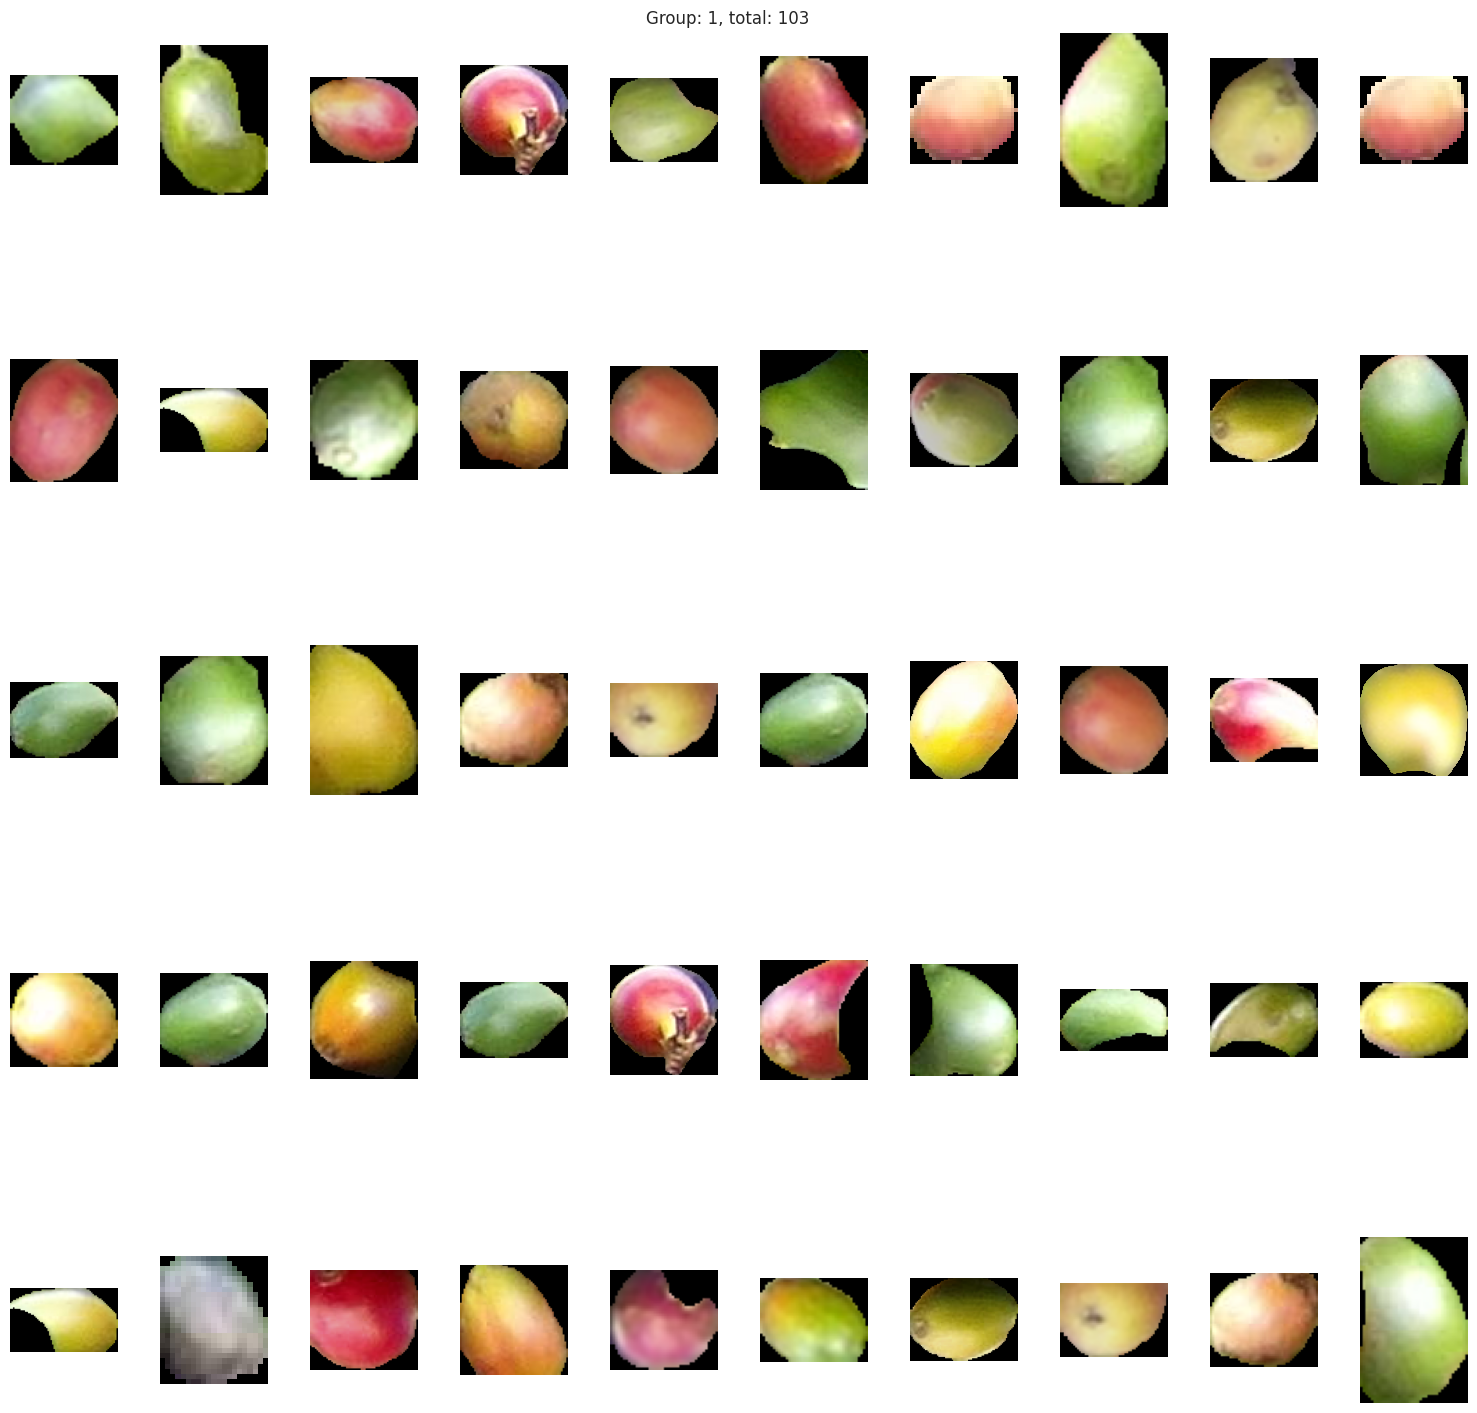

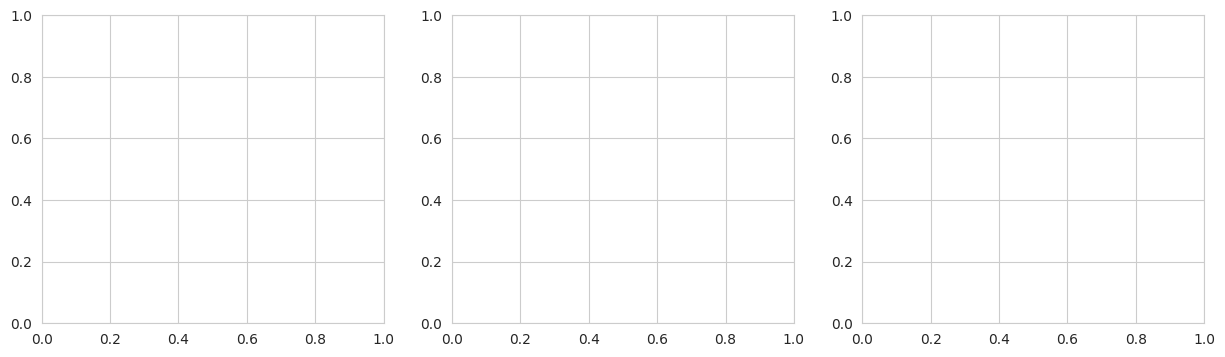

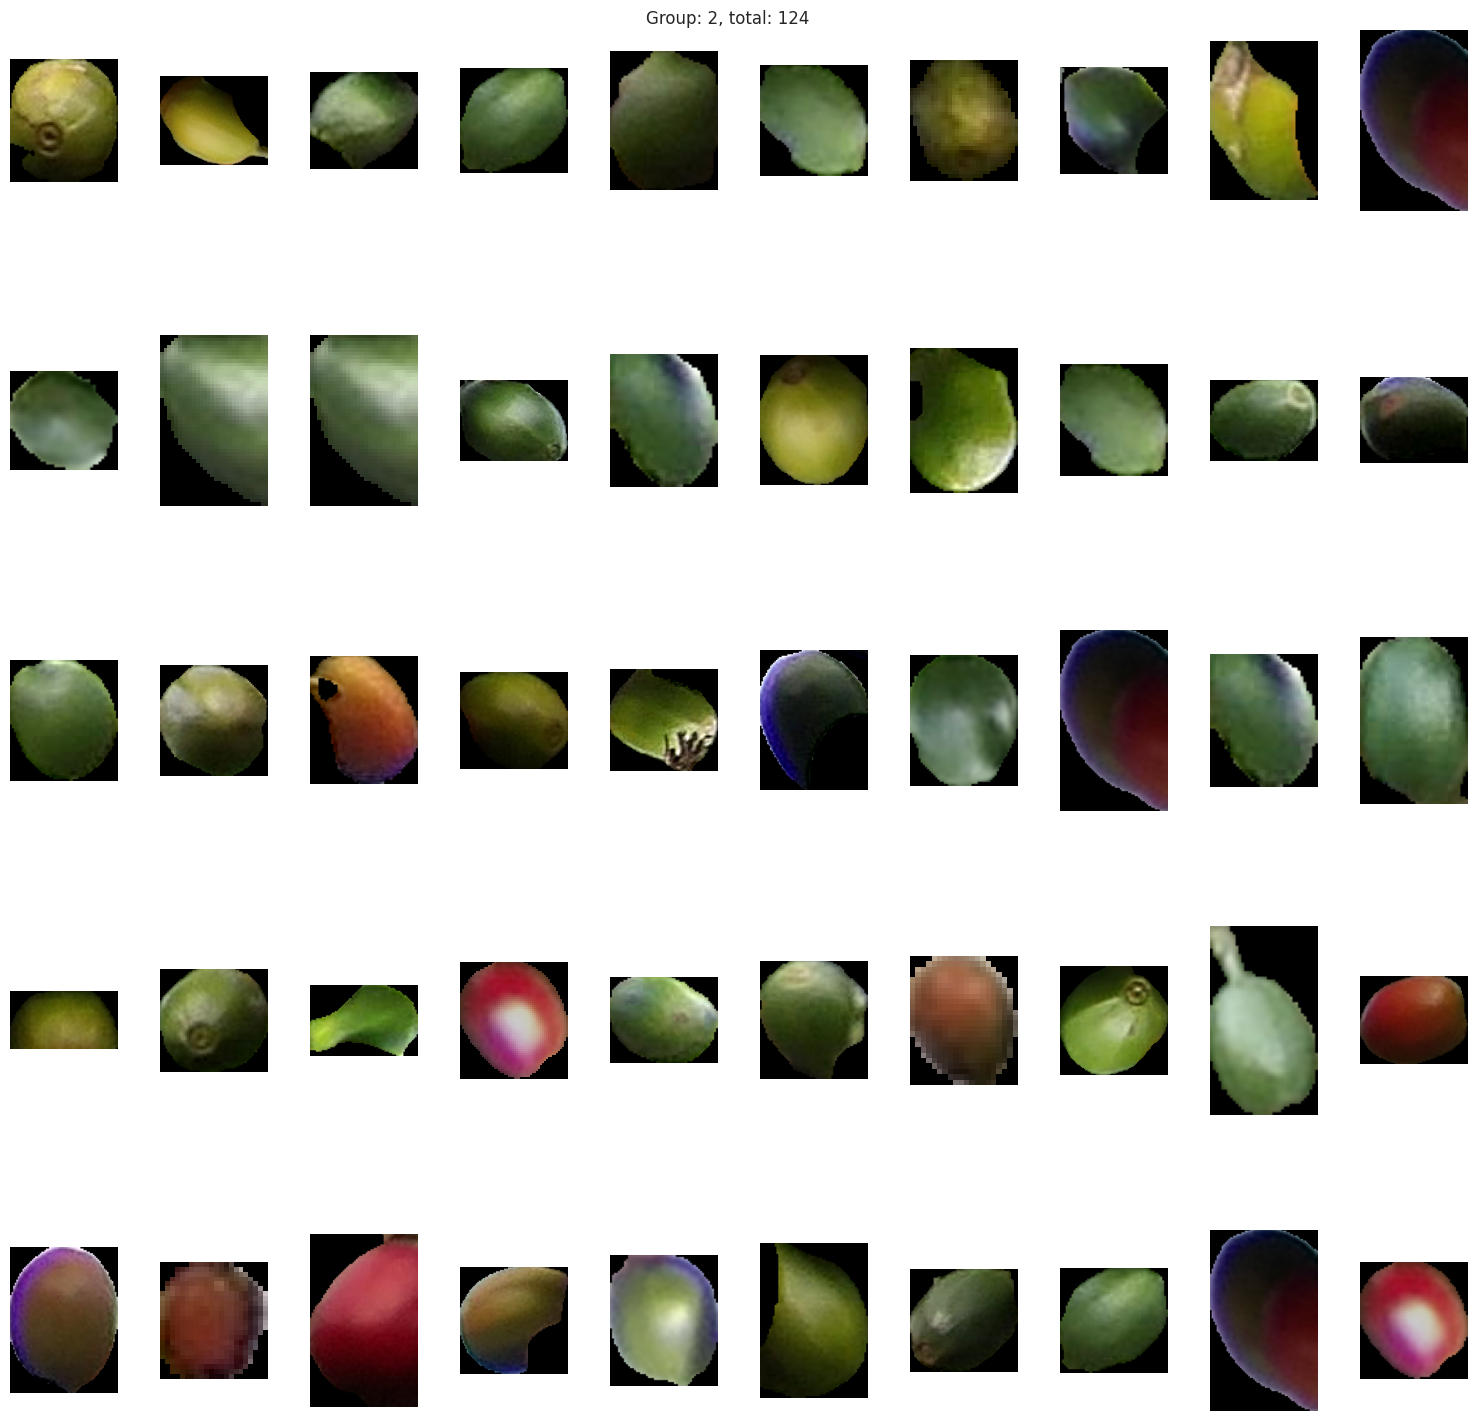

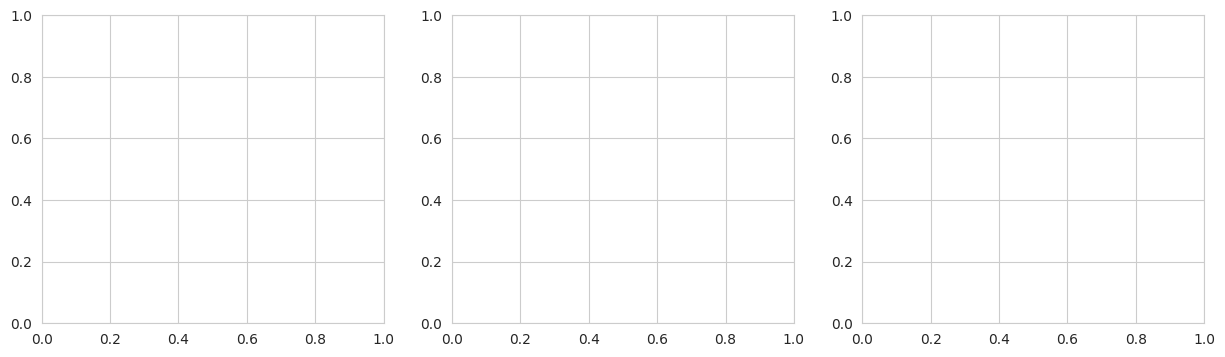

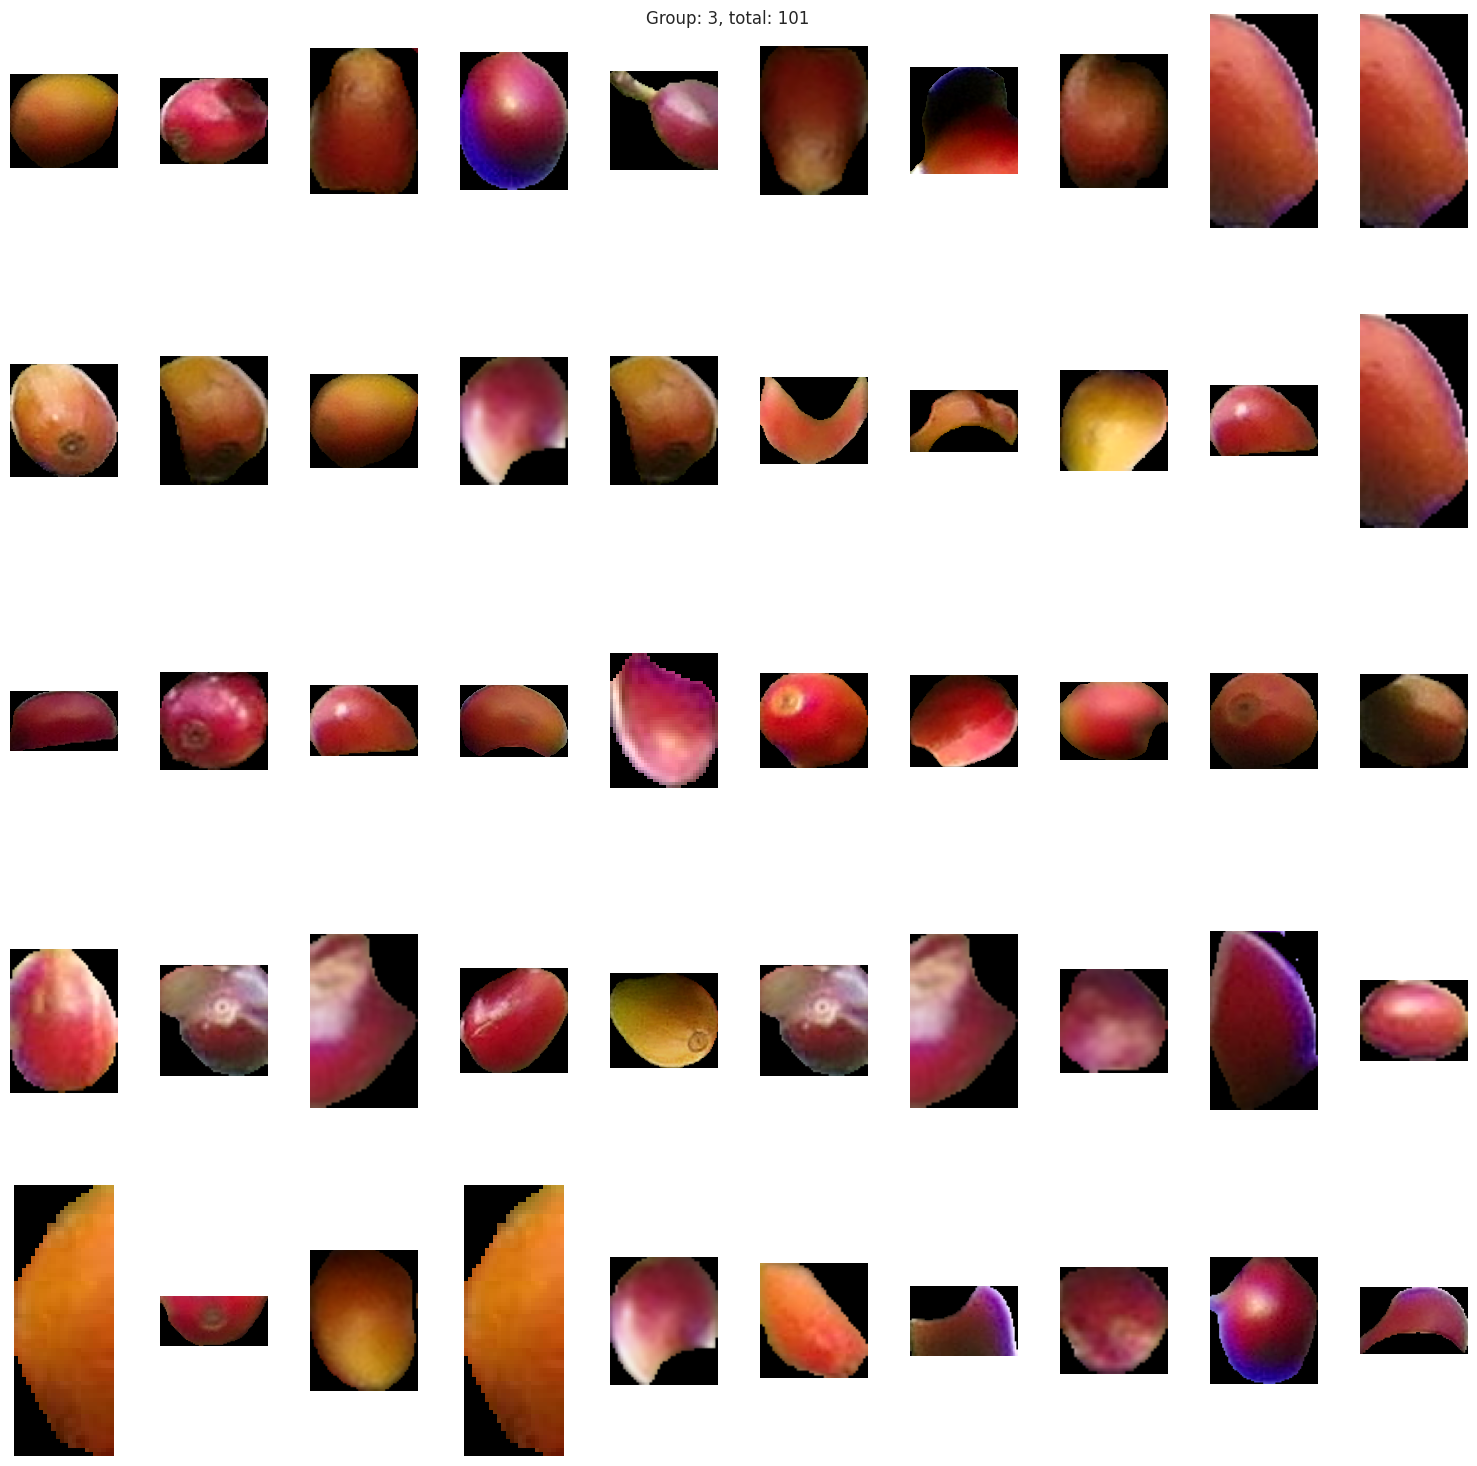

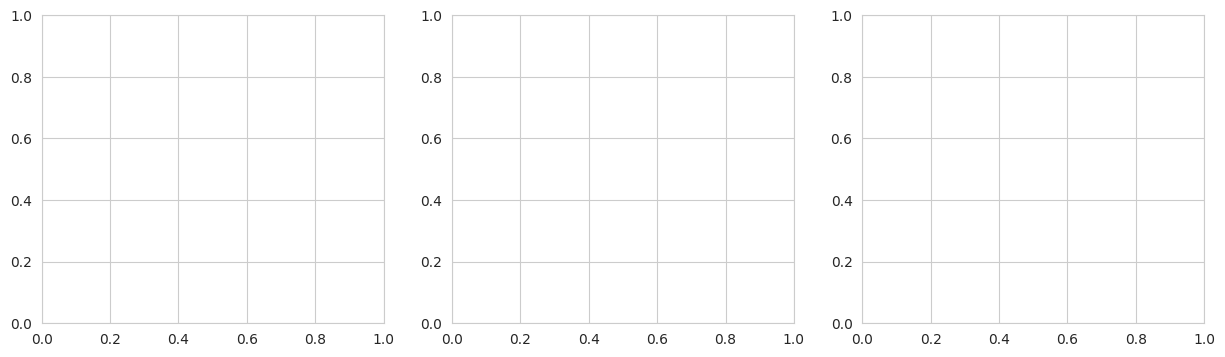

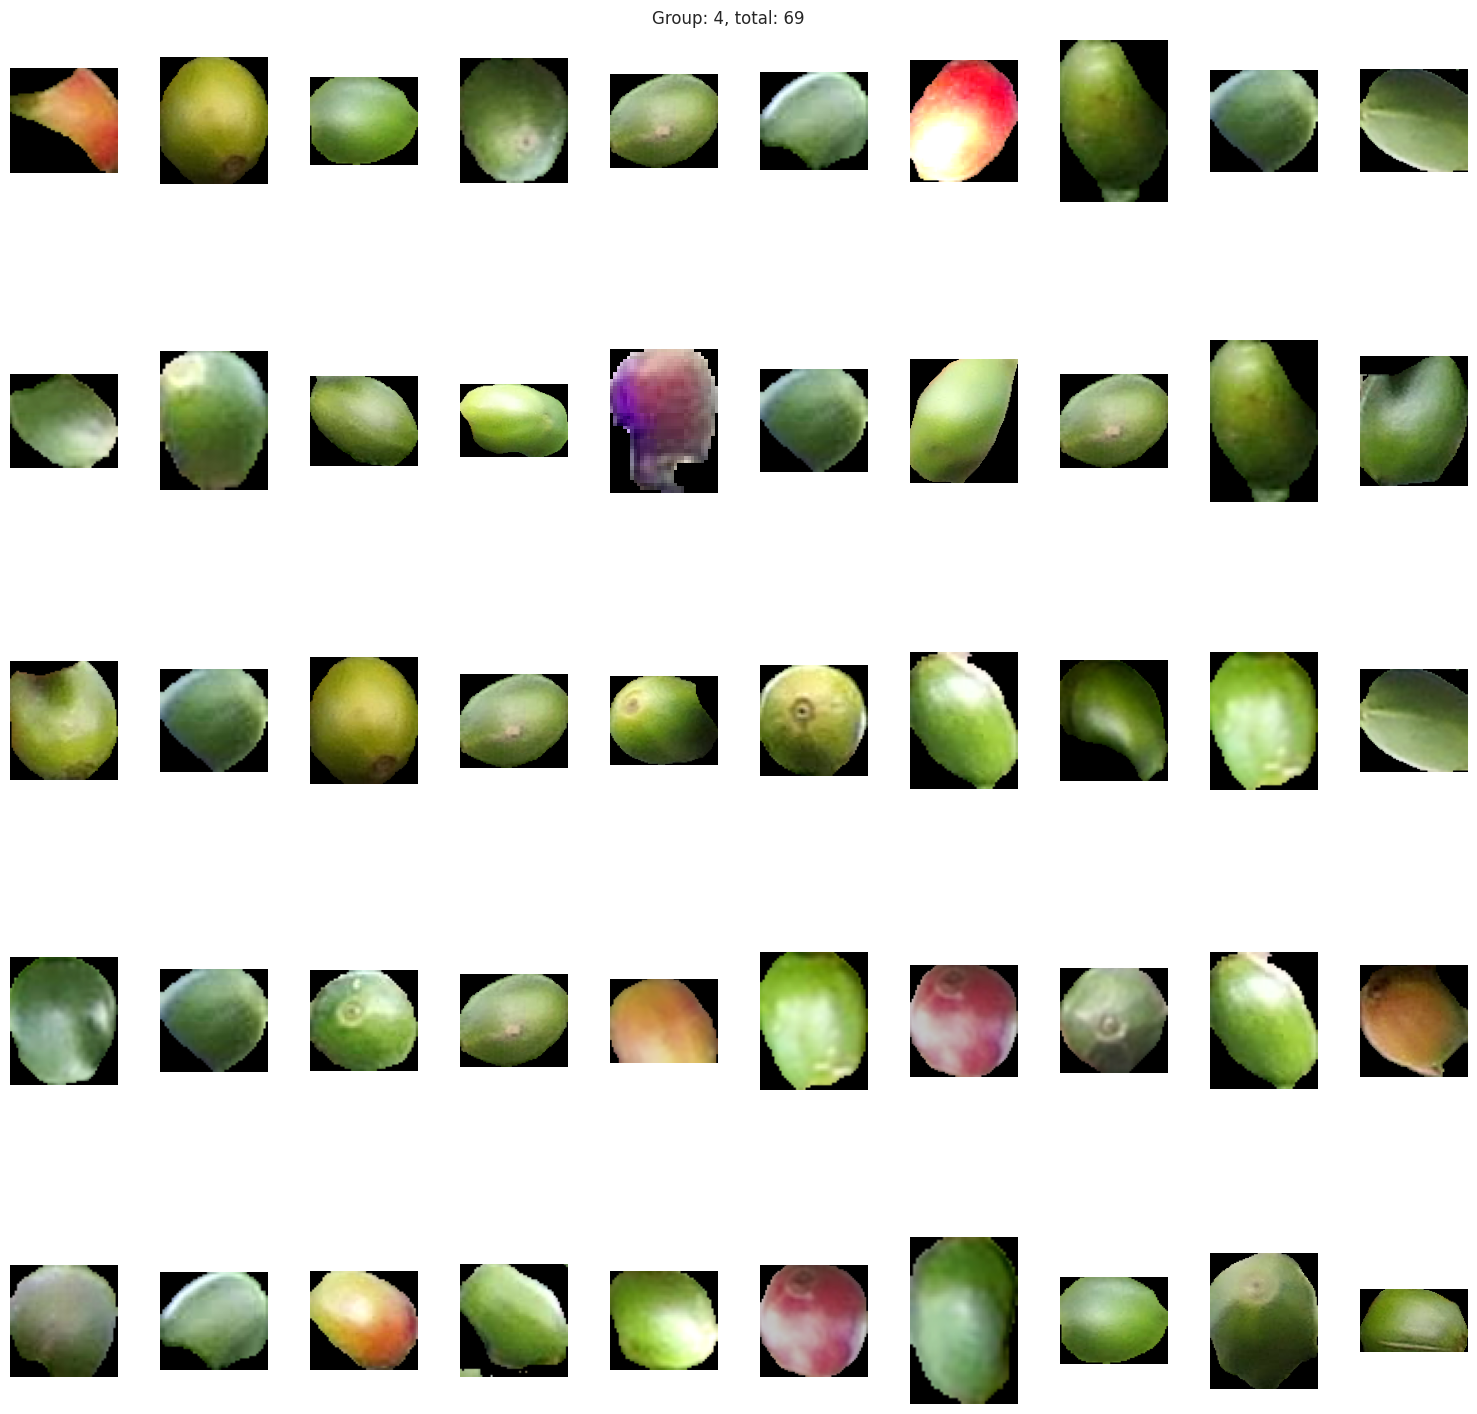

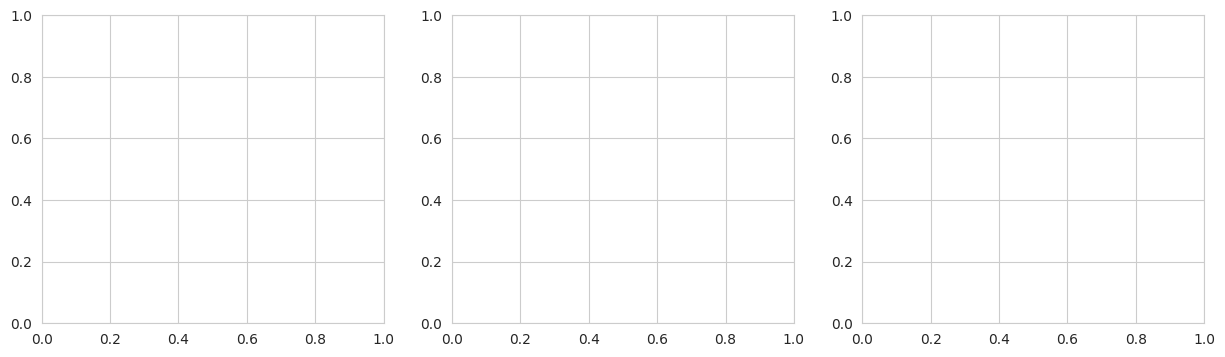

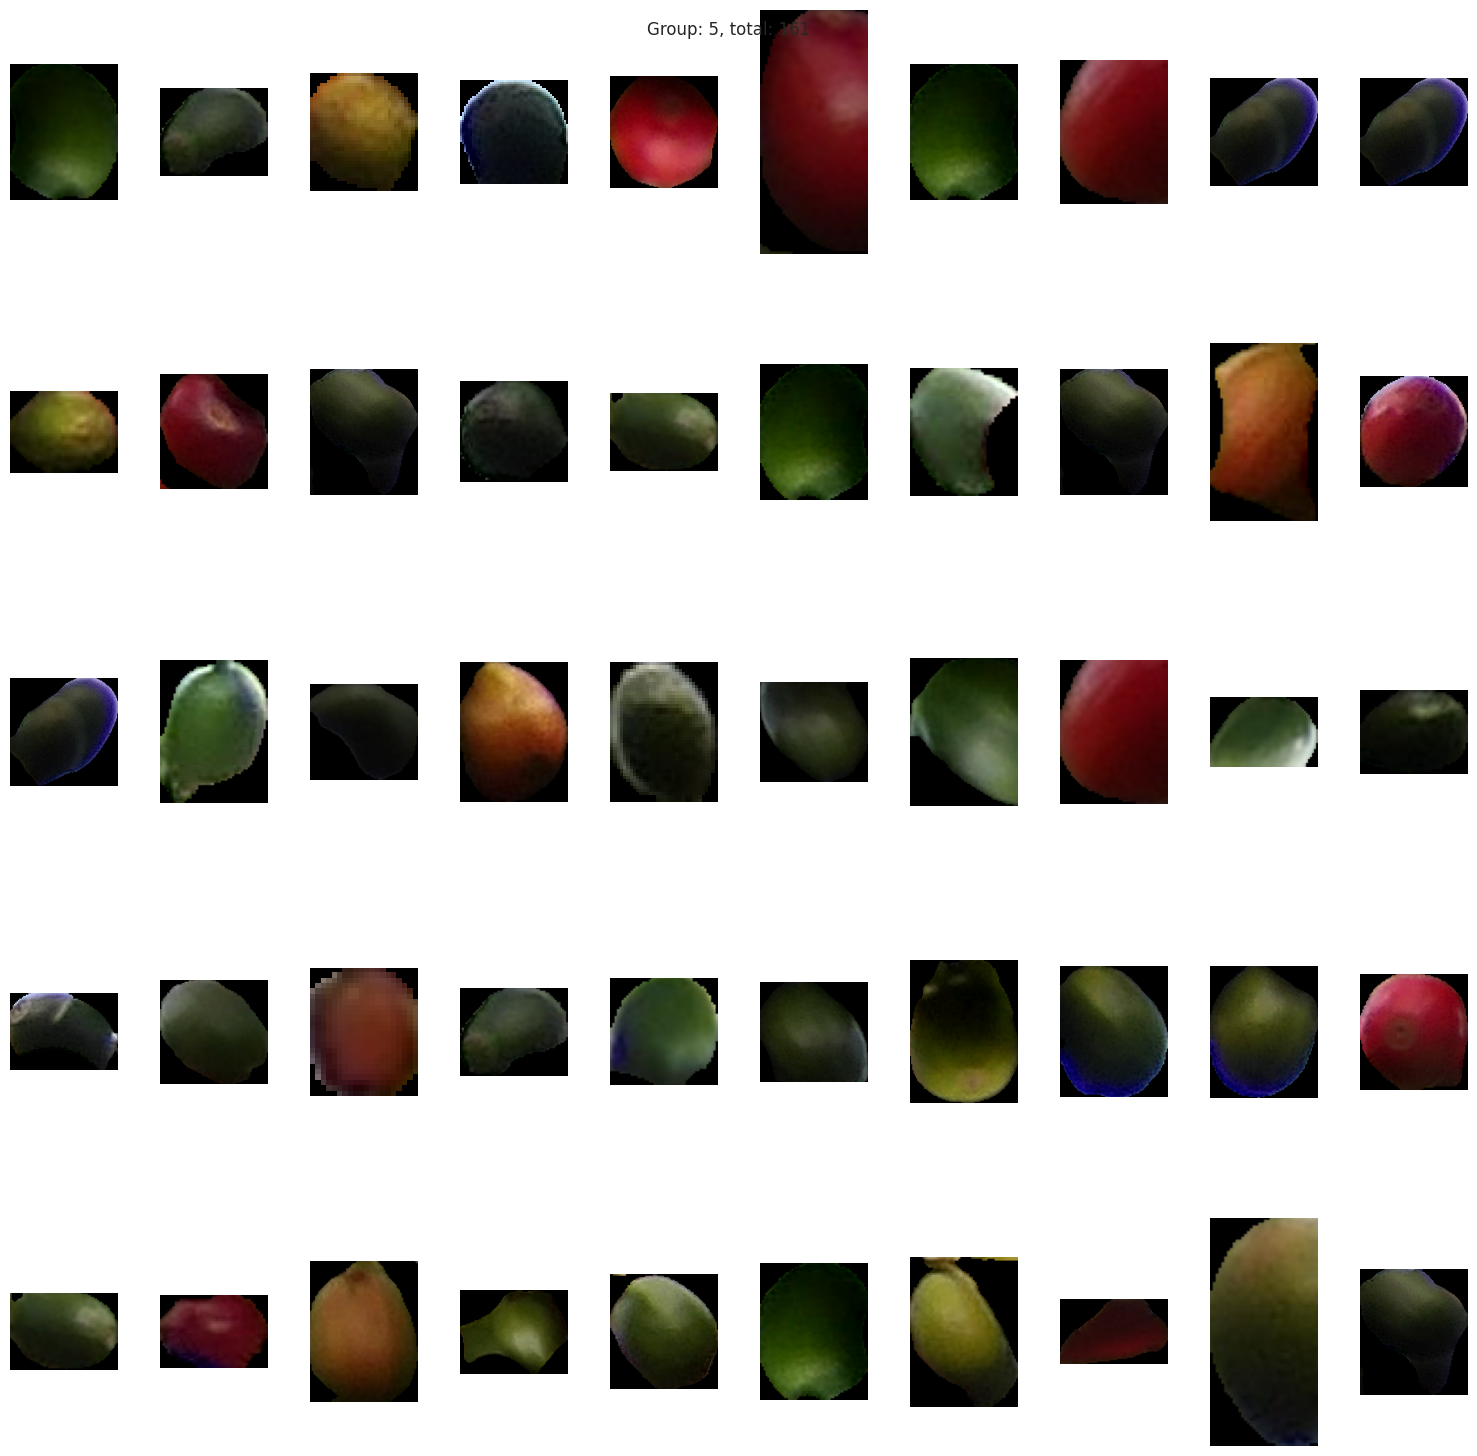

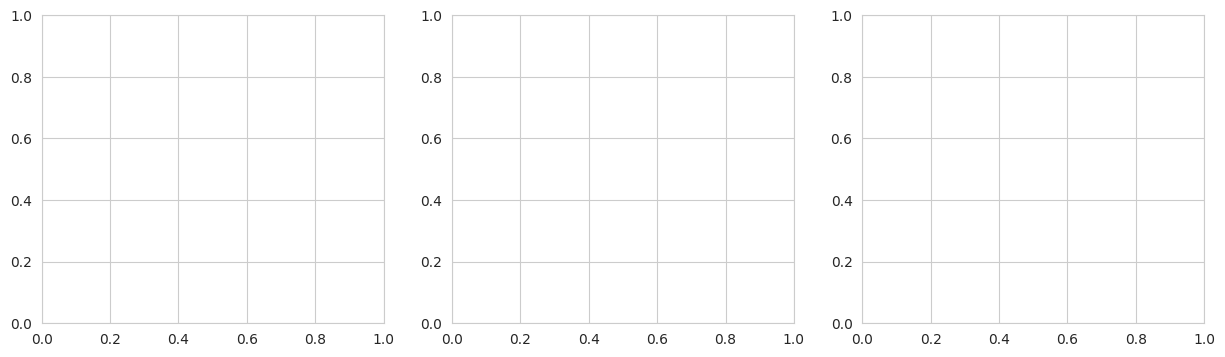

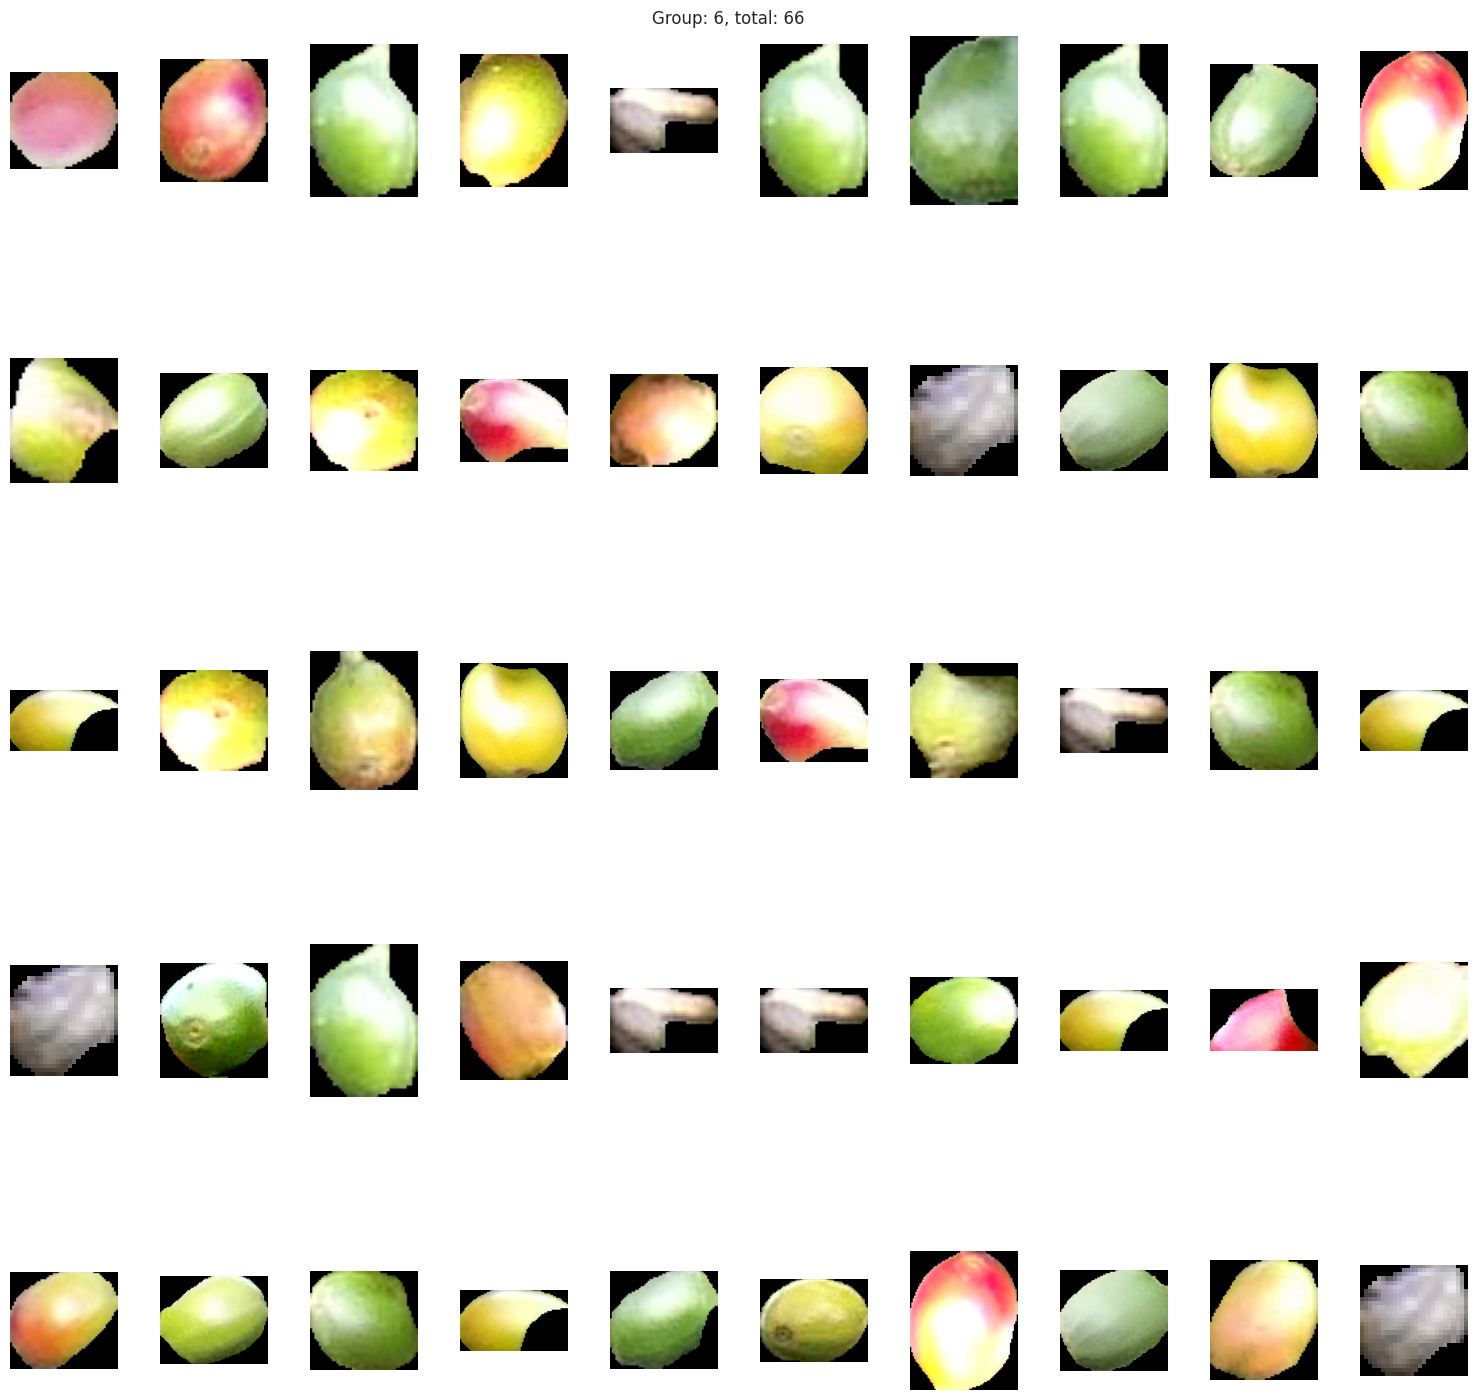

In [18]:
#x = fdf[['red_c', 'green_c', 'blue_c']].to_numpy()

# all columns that start with red_p, green_p, blue_p
x = fdf[[col for col in fdf.columns if col.startswith('red_p') or col.startswith('green_p') or col.startswith('blue_p')]].to_numpy()

from sklearn.cluster import KMeans

best_k, results = best_kmeans(x, range(2, 15))
model = KMeans(n_clusters=best_k, random_state=0)

plt.xlabel('k')
plt.ylabel('Scaled Inertia')
plt.title('Scaled Inertia vs k')
plt.plot(results)
plt.scatter(best_k, results.loc[best_k], c='r', s=100)
plt.show()

model.fit(x)

labels = model.predict(x)
fdf['labels'] = labels

# sns.pairplot(
#     fdf,
#     hue='labels',
#     palette='pastel',
#     size=6,
# )

plot_sample_images_from_groups(fdf)

In [10]:
# import resnet
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

model = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

df = pd.read_csv('validated.csv')

df = df[df['valid'] == True]

features = []

for row in tqdm(df.iterrows(), total=df.shape[0]):
    row = row[1]
    
    image = cv2.imread(row.image)
    mask = np.load(row['mask'])
    
    # grab the image using the mask
    mask = np.array(mask, dtype=np.uint8)
    mask_image = cv2.bitwise_and(image, image, mask=mask)
    mask_image = mask_image[np.ix_(mask.any(1),mask.any(0))]
    mask_image = cv2.resize(mask_image, (224, 224))
    mask_image = mask_image.reshape(1, 224, 224, 3)
    mask_image = preprocess_input(mask_image)
    features.append(model.predict(mask_image, verbose=0))
    
features = np.array(features)

100%|██████████| 177/177 [00:11<00:00, 15.08it/s]


In [11]:
# kmeans clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

cluster = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.90)),
    ('kmeans', KMeans(n_clusters=3))
])

#x = features.reshape(-1, 3)
x = np.concatenate(features, axis=0).reshape(-1, 2048)
x = cluster.fit_transform(x)

/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
